# Big Prey Only
1. With only population dynamics
2. With merged group and population dynamics

Note that need to use unscaled functions, since not using allometric scaling here

In [7]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=14,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=2,        # controls default line thickness
    grid = false,        # turns off grid in background
    fontfamily="Computer Modern" # font family that matches latex
)
using BifurcationKit, DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
bif_fig_path = "/Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"
using LaTeXStrings


## Base Params

Note that I have parameters for small prey here just so the functions (which were originally designed for havign both types of prey) work, but becasue N2 = 0, these do not affect anything

In [2]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 20,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)

u0 = [0.9, 0.1, 0.4, fill(0.0,params_base[:x_max]-2)...]
p_nt = NamedTuple(scale_parameters(params_base))

(A1 = 0.6, α1_of_1 = 0.05, β2 = 1.0, H2b = 0.0, Tg = 0.01, d = 100.0, β1 = 5.0, η1 = 0.12, H1b = 0.0, A2 = 0.5, s1 = 2.0, H1a = 0.0, H2a = 0.0, scale = 5.0, x_max = 20, α2_of_1 = 0.95, η2 = 0.6, α2_fun_type = "constant", s2 = 2.0)

# Useful Functions

In [4]:
function simulate_and_plot_1prey(
        u0, p_nt; tf = 500, system = CoupledDynamics_1Prey_ODE!,
        start_ind = nothing
        )

        # simulate
        tspan = (0.0, tf)
        prob = ODEProblem(system, u0, tspan, p_nt)
        sol = solve(prob)    

        # plot  N1 vs P, then N1 vs mean_x
        # Extract N1, P, mean_x from the solution
        N1 = sol[1, :]  # First component of the solution
        g = sol[2:end, :]  # Second component of the solution
        mean_x = get_meanx(g, p_nt.x_max)'
        P = get_p(g, p_nt.x_max)'

        # Plot N1 vs P
        plot1 = plot(N1, P, xlabel="N1", ylabel="P", title="N1 vs P", legend=false, 
                xlims = (0,1), color = :black)
        if start_ind === nothing
            start_ind = round(Int,length(N1)/5)
        end
        plot!(N1[start_ind:start_ind+1], P[start_ind:start_ind+1], 
                arrow=true, linewidth=2,  legend=false, color = :black)

        plot2 = plot(sol.t, [N1, mean_x, P], label=["N1" "mean_x" "P"], 
            xlabel="Time", ylabel="Population")
        # Add an arrow to indicate direction
        # Choose a point and the next point to determine the arrow's direction

        fullplot = plot(plot1, plot2, layout = (2,1))
        output = (sol, fullplot)
        return output
    end

    function get_stable_equilibria_from_br(br_coexist, params;
        type_system = :oneprey)
        filtered_coexist = extract_branch_matrix(
            br_coexist, params[:x_max];
            type_system = type_system
        )
        indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)

        stable_coexist = Dict()
        for (key, value) in pairs(filtered_coexist)
            stable_coexist[key] = value[indices]
        end

        # store g's in a matrix
        gmat = fill(1.0, (length(stable_coexist[:N1]), params[:x_max]))
        for i in 1:x_max
            gmat[:,i] = stable_coexist[Symbol("g$i")]
        end
        return stable_coexist, gmat
    end

# this function is copied from ApparentCompetition.ipynb
function plot_distribution_heatmap(gmat, stable_coexist, x_max;
    cbar_label = L"\textrm{Prob.\ in\ group\ size}\ x")
    # prob_x_mat: matrix (rows = param values, cols = x values)
    prob_x_mat = get_prob_in_x(gmat, stable_coexist[:P], x_max);
    # stable_coexist[:param]: vector for x-axis
    # xvec: vector for y-axis (e.g., 1:x_max)
    xvec = 1:x_max
    plt_heat = heatmap(
        stable_coexist[:param], 
        xvec, 
        prob_x_mat', 
        color = :coolwarm,         # black (1) to white (0)
        clim = (0, maximum(prob_x_mat) + .01),          # scale from 0 (white) to 1 (black)
        xlabel = param_label_dic[:scale], 
        ylabel = L"Group size, $x$",
        right_margin = 15mm,
        #colorbar_titlefontrotation = 180,
        yflip = false            # optional: flip y-axis if you want black at the top
    )
    plot!(
        stable_coexist[:param],
        stable_coexist[:mean_x],
        label = L"\bar{x}",
        color = :black,
        linewidth=4
    )
    annotate!(
        (1.2, 0.5),
        text(cbar_label, 16, :center, rotation = -90),
        
    )
    return plt_heat
end


function find_mangel_clark(N1, N2, params)
    # Mangel and Clark predicted that groups should grow until W(x^*) = W(1)
    # Simplest way: iterate and stop when W(x) < W(1), then return x - 1
    @unpack x_max = params
    W_of_1 = fun_W(1, N1, N2, params)
    for x in 2:x_max
        W_of_x = fun_W(x, N1, N2, params)
        if W_of_x < W_of_1
            return x - 1
        end
    end
    return x_max  # If reach x_max
end

function plot_mc_line_1prey(plt, stable_coexist, params_base)
    x_list_mangel_clark = []
    params = deepcopy(params_base)
    N2 = 0

    for (i,param) in enumerate(stable_coexist[:param])
        # get parameter value and prey value
        N1 = stable_coexist[:N1][i]
        params[:scale] = param

        # update parameters dictionary using scaling laws
        params = scale_parameters(params)

        # get mangel and clark prediction
        x_mc = find_mangel_clark(N1, N2, params)
        push!(x_list_mangel_clark, x_mc)
    end
    # plot
    plot!(stable_coexist[:param], x_list_mangel_clark, color = :yellow,
    label=L"$\hat{x}$")
end

function plot_opt_line_1prey(plt, stable_coexist, params_base)
    """
    Plots the group size that maximizes fitness atht eequilibrium
    """
    x_list = []
    params = deepcopy(params_base)
    N2 = 0
    for (i,param) in enumerate(stable_coexist[:param])
        # get parameter value and prey values
        N1 = stable_coexist[:N1][i]
        params[:scale] = param

        # update parameters dictionary using scaling laws
        params = scale_parameters(params)

        # get mangel and clark prediction
        W = fun_W(1:params_base[:x_max], N1, N2, params)
        x_opt = findmax(W)[2]
        push!(x_list, x_opt)
    end
    plot!(
        stable_coexist[:param], x_list, color = :purple,
        linewidth=5,
        label = L"x^*"
        )

end

plot_opt_line_1prey (generic function with 1 method)

# Coupled Dynamics

## TYPE I, VARY SCALE (manual)

In [8]:
p_nt = NamedTuple(scale_parameters(params_base))
# inputs to the functins
x_max = p_nt.x_max
systemfunction = CoupledDynamics_1Prey_ODE
lens = (@optic _.scale)
p_min = 1.01; p_max = 8.0; dsmax = 0.01
type_system = :oneprey
kargs = (
            systemfunction = systemfunction, 
            lens = lens, p_min = p_min, 
            p_max = p_max,
            type_system = :oneprey)
record_from_solution = recordFromSolution_1Prey
systemfunction = CoupledDynamics_1Prey_ODE 

opts_br = ContinuationPar(
            # parameter interval
            p_min = p_min, p_max = p_max, dsmax = dsmax,
            # detect bifurcations with bisection method
            # we increase the precision of the bisection
            n_inversion = 8 )


# coexistence
    u0 = [0.8, 0.1, fill(0.001, x_max-1)...]
    u0 = iterate_to_last_pt_scaled(u0, p_nt; tf = 500, systemfunction = systemfunction)

    prob = BifurcationProblem(systemfunction, u0, p_nt,
                # specify the continuation parameter)
                lens, record_from_solution = record_from_solution)
    br_co = continuation(prob, PALC(), opts_br; bothside = true)

#### predators extinct
u1 = [1.0,zeros(x_max)...]
prob = BifurcationProblem(systemfunction, u1, p_nt,
                lens, record_from_solution = record_from_solution)
br_P_extinct = continuation(prob, PALC(), opts_br; bothside = true)

### big prey and predator extinct
u0 = zeros(x_max+1)
br_N1P_extinct = continuation(BifurcationProblem(systemfunction, u0, p_nt,
                lens, record_from_solution = record_from_solution),
                PALC(), opts_br; bothside = true)



br_list = (coexist = br_co, predator_extinct = br_P_extinct, 
                    N1P_extinct = br_N1P_extinct)

(coexist =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 615
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.4507108554323505, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.45064947,                                                                     step =  -1
- #  2,       bp at scale ≈ +1.49999997 ∈ (+1.49999997, +1.50000001), |δp|=3e-08, [converged], δ = (-1,  0), step = 137
- #  3, endpoint at scale ≈ +8.00000000,                                                                     step = 614
, predator_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 499
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.01000000,                                                                     step =   0
- #  2,       bp at scale ≈ +1.07158318 ∈ (+1.07158318, +1.07158663), |δp|=3e-06, [converged], δ = (-1,  0), step = 

hi

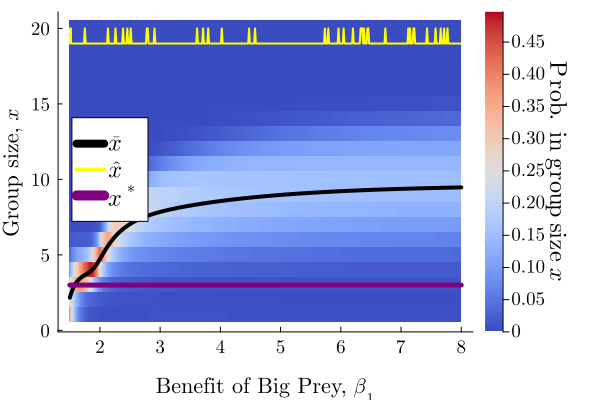

In [9]:
# get all the stable values and put in stable_coexist. separately also put g values in gmat
stable_coexist, gmat = get_stable_equilibria_from_br(br_co, p_nt;
        type_system = :oneprey)
plt = plot_distribution_heatmap(gmat, stable_coexist, p_nt.x_max)
plot_mc_line_1prey(plt, stable_coexist, params_base)
plot_opt_line_1prey(plt, stable_coexist, params_base)
plot!(legend = :left, legendfontsize = 16)
plot!(dpi = 600)
plot!(xlabel = "\n"*L"Benefit of Big Prey, $\beta_1$")
savefig(plt, bif_fig_path*"bif_1prey_scale_T1_px.pdf")
plot!(dpi = 100)

plt

In [10]:
params[:x_max]

UndefVarError: UndefVarError: `params` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Distributions in the current active module Main

hi

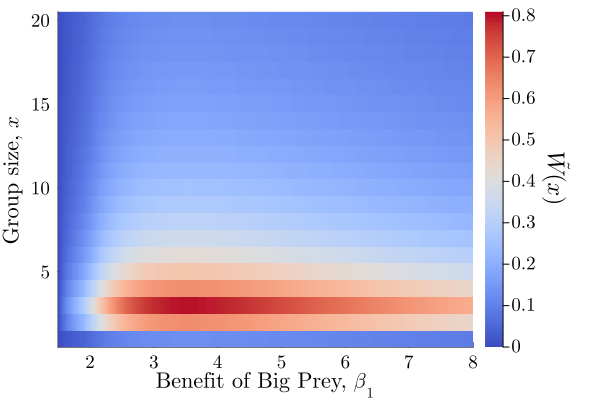

In [11]:
stable_coexist, gmat = get_stable_equilibria_from_br(br_co, p_nt;
        type_system = :oneprey)
paramkey = :β1
xvec = 1:params_base[:x_max]

W_mat = similar(gmat)
for (i,param) in enumerate(stable_coexist[:param])
    params = deepcopy(params_base)
    params[paramkey] = param
    params = scale_parameters(params)
    N1 = stable_coexist[:N1][i]
    Wvec = fun_W(xvec, N1, 0, params)
    W1 = Wvec[1]
    W_mat[i,:] = Wvec
end

xvec = 1:x_max
plt_heat = heatmap(
    stable_coexist[:param], 
    xvec, 
    W_mat', 
    color = :coolwarm,         # black (1) to white (0)
    clim = (0, maximum(W_mat) + .01),          # scale from 0 (white) to 1 (black)
    xlabel = L"Benefit of Big Prey, $\beta_1$", 
    ylabel = L"Group size, $x$",
    right_margin = 15mm,
    #colorbar_titlefontrotation = 180,
    yflip = false            # optional: flip y-axis if you want black at the top
)

    annotate!(
        (1.2, 0.5),
        text(L"\tilde{W}(x)", 16, :center, rotation = -90),
        
    )
savefig(plt_heat, bif_fig_path*"bif_1prey_scale_T1_W.pdf")
plt_heat

In [12]:
methods(fun_W)

# 1 method for generic function "fun_W" from CooperativeHuntingPkg.ModelHelperFuns:
 [1] fun_W(x, N1, N2, parameters)
     @ ~/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/ModelHelperFuns.jl:104

hihihi

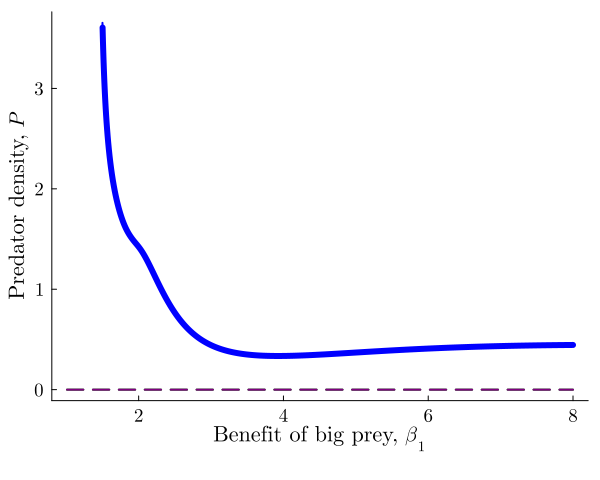

In [512]:
methods(plot_nice_bif)
pltP = plot_nice_bif(br_list, :P, :β1; x_max = p_nt.x_max, 
has_g = true, type_system = :oneprey)
plot!(xlabel = L"Benefit of big prey, $\beta_1$")
plot!(dpi=650)
savefig(pltP, bif_fig_path*"bif_1prey_scale_T1_P.pdf")
pltP
plot!(dpi=100)

hihihi

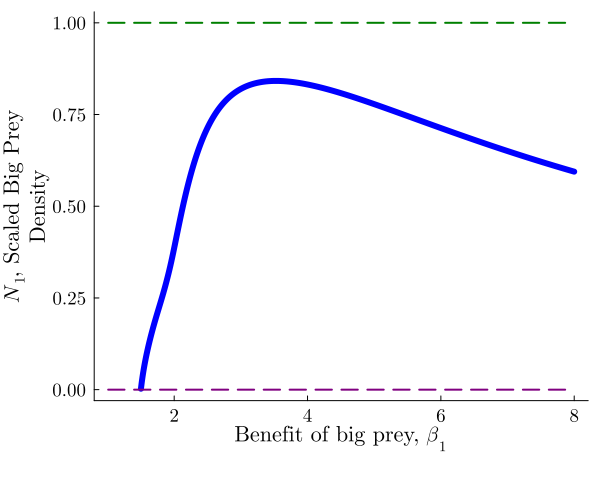

In [496]:
pltN = plot_nice_bif(br_list, :N1, :β1; x_max = p_nt.x_max, 
has_g = true, type_system = :oneprey)
plot!(xlabel = L"Benefit of big prey, $\beta_1$")
plot!(dpi=650)
savefig(pltN, bif_fig_path*"bif_1prey_scale_T1_N.pdf")
pltN
plot!(dpi=100)

In [519]:
findmin(out_nt.P)

(0.33534011073664094, 188)

hi

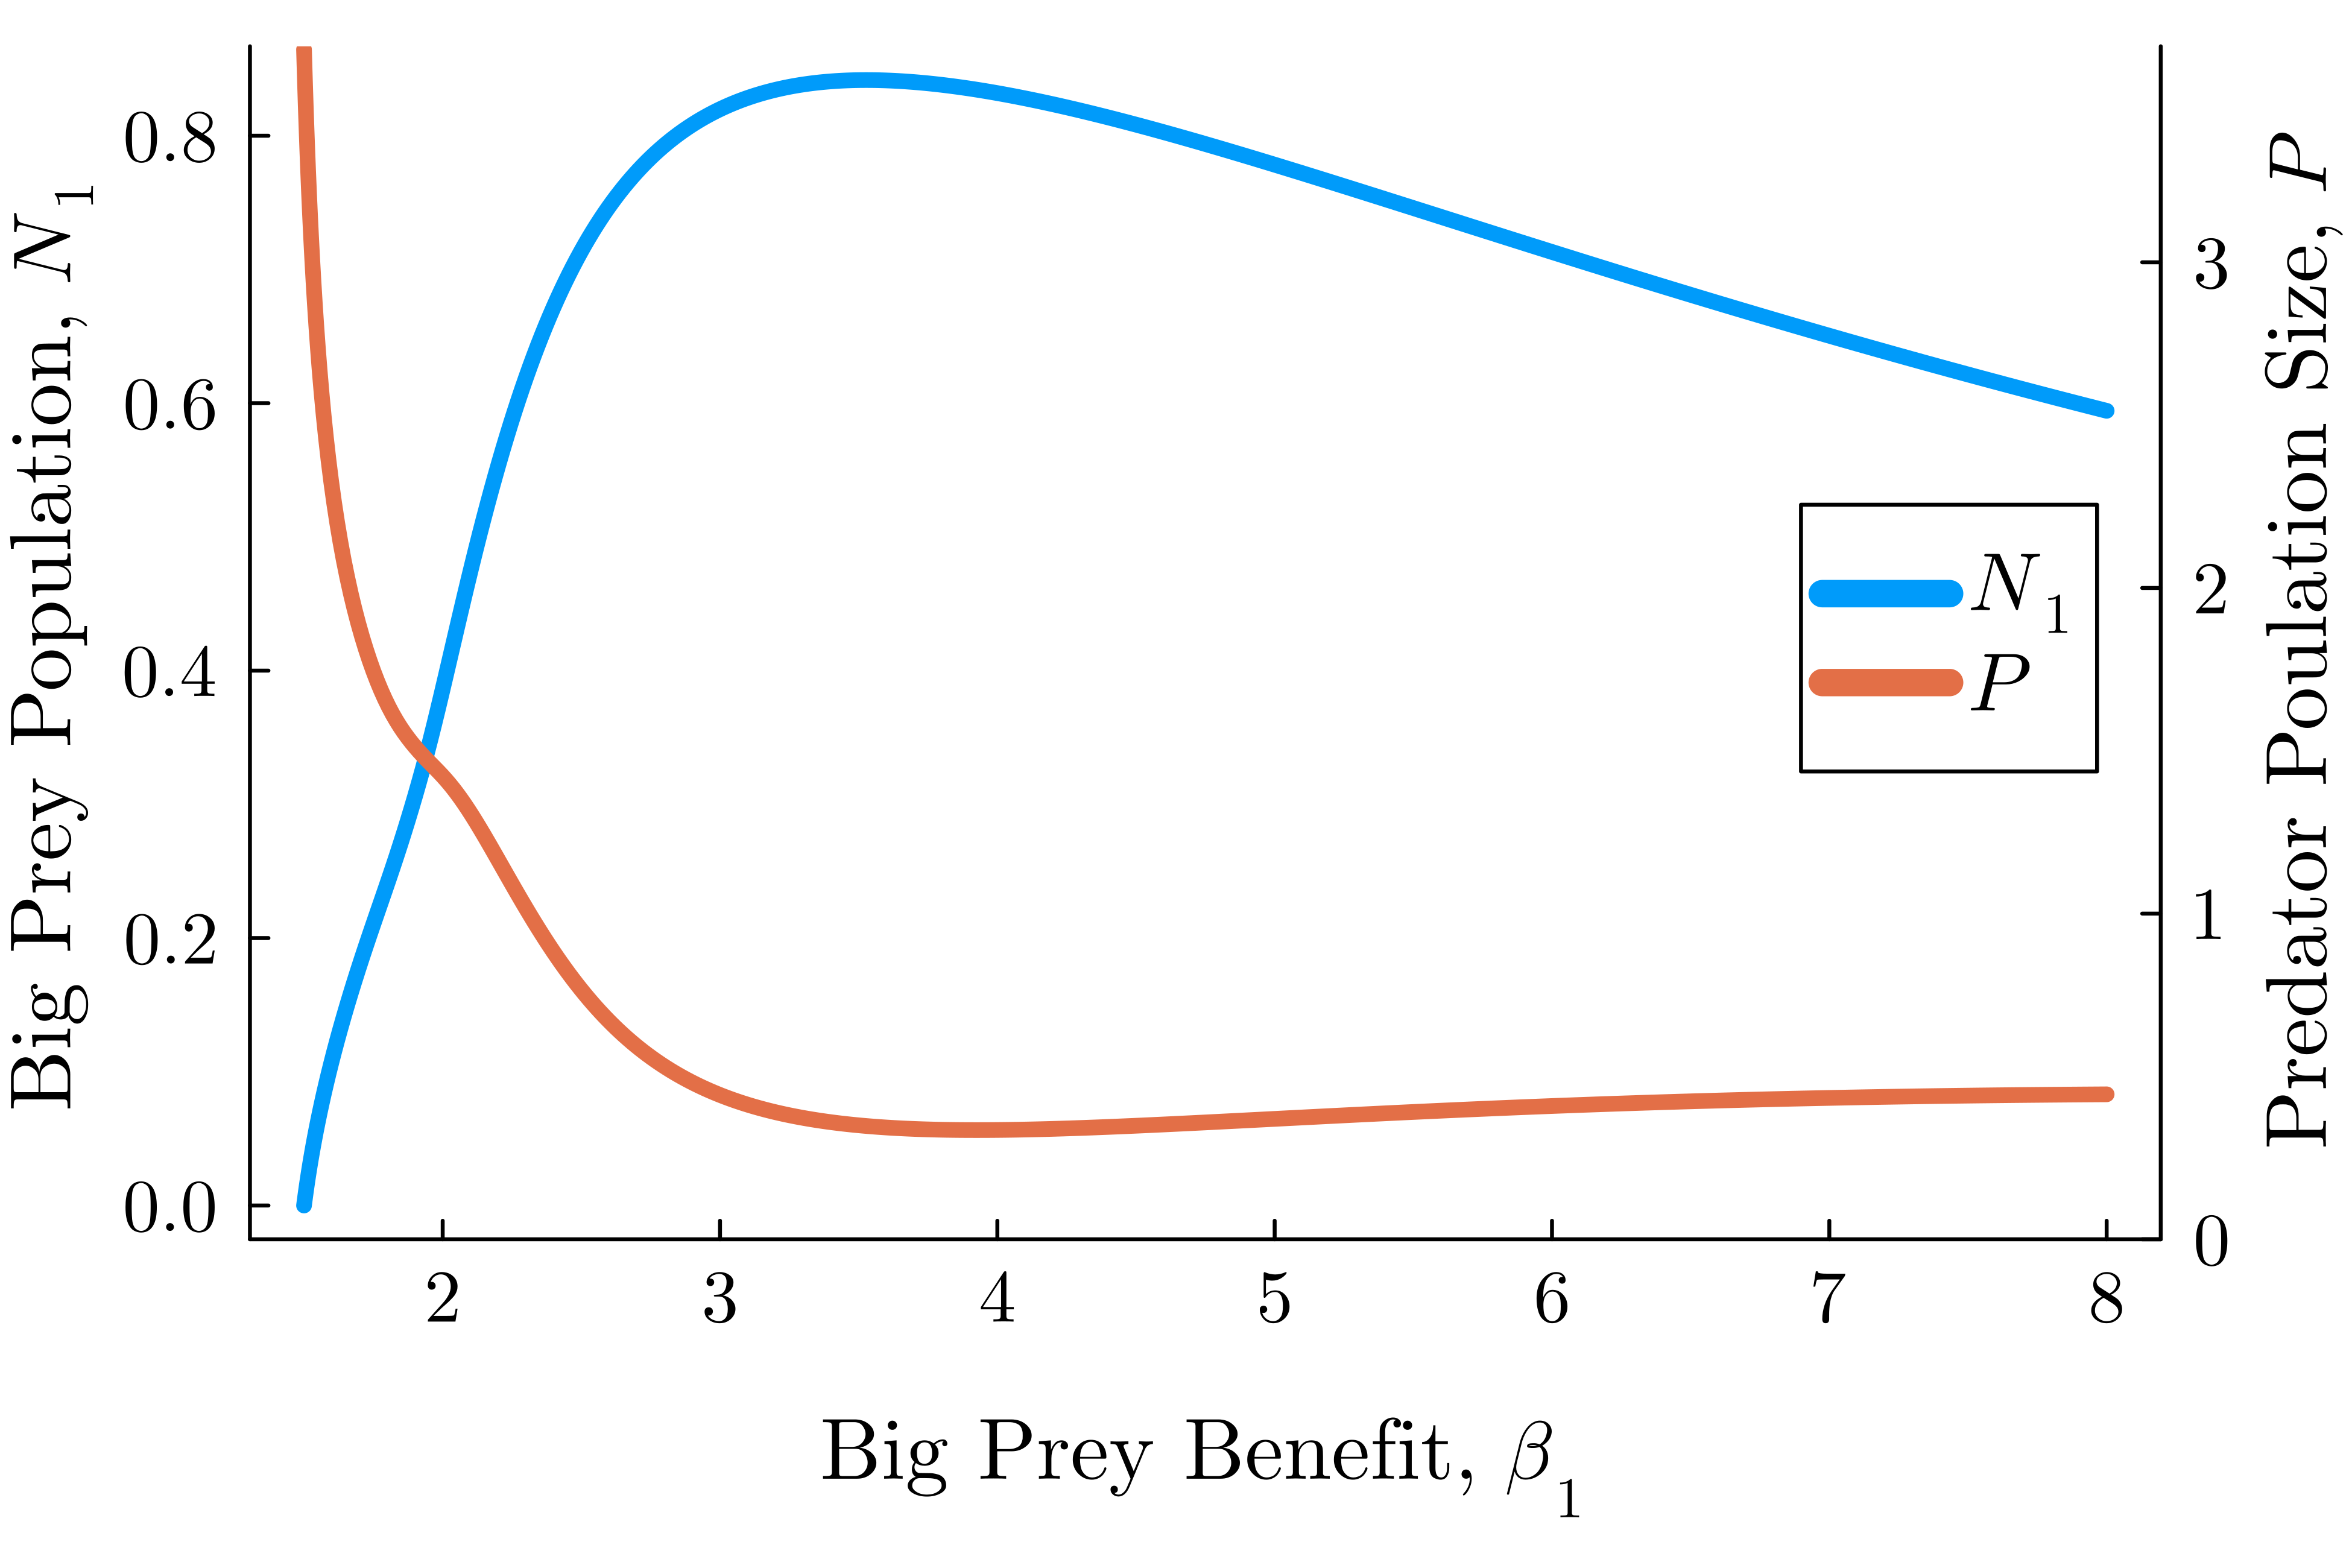

In [520]:
out_nt = extract_branch_matrix(br_list[:coexist], p_nt.x_max; type_system = :oneprey)

plt = plot(
    out_nt.param, out_nt.N1, label = L"N_1", color = 1, linewidth = 4,
    ylabel = L"Big Prey Population, $N_1$",
    xlabel = "\n"*L"Big Prey Benefit, $\beta_1$",
    bottommargin=5mm)
plot!([],[],label = L"P", color = 2, linewidth = 4)
plot!(legend=:right)
plot!(
    twinx(), out_nt.param, out_nt.P, label = "", color = 2, linewidth = 4,
    ylabel = L"Predator Poulation Size, $P$",
    ylim = [0, findmax(out_nt.P)[1]+0.01]
)
plot!(dpi=650)
savefig(plt, bif_fig_path*"bif_1prey_scale_T1.pdf")
plt

hihihihihihihihihihihihihi

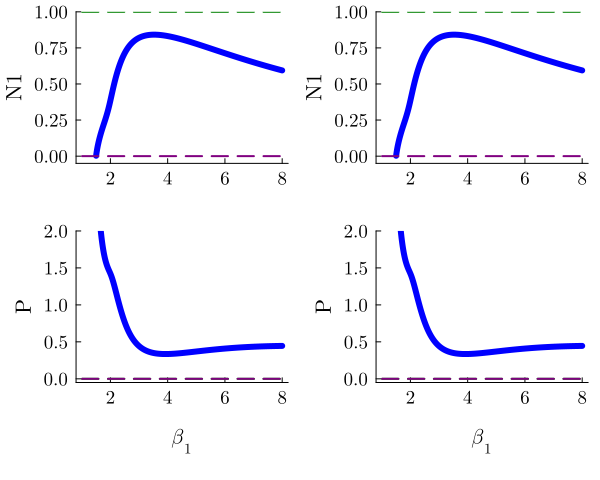

In [197]:
plot_comparison_branches_filtered(
        br_list, br_list,:β1; 
        ymax = 2.0, has_g = true, x_max = 5,
        plot_fun = plot_nice_bif,
        type_system = :oneprey)

## Type II, Vary Sclae

### H2b = 1.0... too much handling time!

In [14]:
params = deepcopy(params_base)
params[:H2b] = 1.0
p_nt = NamedTuple(scale_parameters(params))

(A1 = 0.6, η1 = 0.12, H2b = 1.0, s1 = 2.0, H1a = 0.0, H2a = 0.0, scale = 5.0, x_max = 20, α2_of_1 = 0.95, η2 = 0.6, α2_fun_type = "constant", s2 = 2.0, α1_of_1 = 0.05, Tg = 0.01, d = 100.0, β1 = 5.0, H1b = 6.0, A2 = 0.5, β2 = 1.0)

In [15]:
# inputs to the functins
x_max = p_nt.x_max
systemfunction = CoupledDynamics_1Prey_ODE
lens = (@optic _.scale)
p_min = 1.01; p_max = 8.0; dsmax = 0.01
type_system = :oneprey
kargs = (
            systemfunction = systemfunction, 
            lens = lens, p_min = p_min, 
            p_max = p_max,
            type_system = :oneprey)
record_from_solution = recordFromSolution_1Prey
systemfunction = CoupledDynamics_1Prey_ODE 

opts_br = ContinuationPar(
            # parameter interval
            p_min = p_min, p_max = p_max, dsmax = dsmax,
            # detect bifurcations with bisection method
            # we increase the precision of the bisection
            n_inversion = 8 )


# coexistence
    u0 = [0.8, 0.1, fill(0.001, x_max-1)...]
    u0 = iterate_to_last_pt_scaled(u0, p_nt; tf = 500, systemfunction = systemfunction)

    prob = BifurcationProblem(systemfunction, u0, p_nt,
                # specify the continuation parameter)
                lens, record_from_solution = record_from_solution)
    br_co = continuation(prob, PALC(), opts_br; bothside = true)

#### predators extinct
u1 = [1.0,zeros(x_max)...]
prob = BifurcationProblem(systemfunction, u1, p_nt,
                lens, record_from_solution = record_from_solution)
br_P_extinct = continuation(prob, PALC(), opts_br; bothside = true)

### big prey and predator extinct
u0 = zeros(x_max+1)
br_N1P_extinct = continuation(BifurcationProblem(systemfunction, u0, p_nt,
                lens, record_from_solution = record_from_solution),
                PALC(), opts_br; bothside = true)



br_list = (coexist = br_co, predator_extinct = br_P_extinct, 
                    N1P_extinct = br_N1P_extinct)

(coexist =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 499
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.01000000,                                                                     step =   0
- #  2,     hopf at scale ≈ +1.11971744 ∈ (+1.11971744, +1.11972435), |δp|=7e-06, [converged], δ = (-2, -2), step =   8
- #  3,     hopf at scale ≈ +1.14335442 ∈ (+1.14335442, +1.14336133), |δp|=7e-06, [converged], δ = (-2, -2), step =  10
- #  4,       bp at scale ≈ +2.53819851 ∈ (+2.53819851, +2.53819894), |δp|=4e-07, [converged], δ = (-1,  0), step = 109
- #  5, endpoint at scale ≈ +8.00000000,                                                                     step = 498
, predator_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 499
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, en

hihihihihihihihihihihihihi

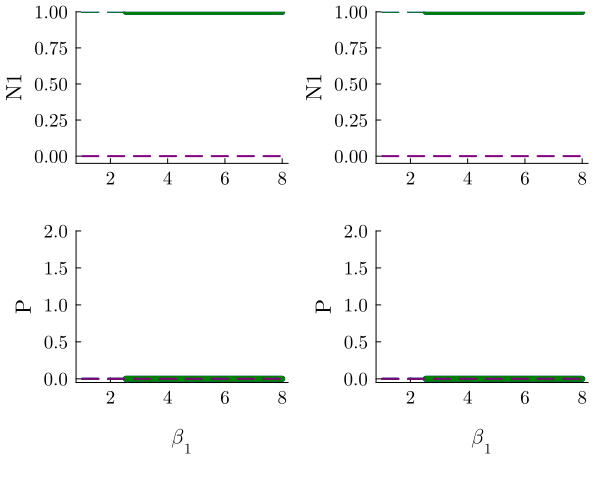

In [16]:
plot_comparison_branches_filtered(
        br_list, br_list,:β1; 
        ymax = 2.0, has_g = true, x_max = 5,
        plot_fun = plot_nice_bif,
        type_system = :oneprey)

## Smaller H2b

In [17]:
params = deepcopy(params_base)
params[:H2b] = 0.4
params[:A1] = 0.6
p_nt = NamedTuple(scale_parameters(params))
# inputs to the functins
x_max = p_nt.x_max
systemfunction = CoupledDynamics_1Prey_ODE
lens = (@optic _.scale)
p_min = 1.01; p_max = 8.0; dsmax = 0.01
type_system = :oneprey
kargs = (
            systemfunction = systemfunction, 
            lens = lens, p_min = p_min, 
            p_max = p_max,
            type_system = :oneprey)
record_from_solution = recordFromSolution_1Prey
systemfunction = CoupledDynamics_1Prey_ODE 

opts_br = ContinuationPar(
            # parameter interval
            p_min = p_min, p_max = p_max, dsmax = dsmax,
            # detect bifurcations with bisection method
            # we increase the precision of the bisection
            n_inversion = 8 )


# coexistence
    u0 = [0.8, 0.1, fill(0.001, x_max-1)...]
    u0 = iterate_to_last_pt_scaled(u0, p_nt; tf = 500, systemfunction = systemfunction)

    prob = BifurcationProblem(systemfunction, u0, p_nt,
                # specify the continuation parameter)
                lens, record_from_solution = record_from_solution)
    br_co = continuation(prob, PALC(), opts_br; bothside = true)

#### predators extinct
u1 = [1.0,zeros(x_max)...]
prob = BifurcationProblem(systemfunction, u1, p_nt,
                lens, record_from_solution = record_from_solution)
br_P_extinct = continuation(prob, PALC(), opts_br; bothside = true)

### big prey and predator extinct
u0 = zeros(x_max+1)
br_N1P_extinct = continuation(BifurcationProblem(systemfunction, u0, p_nt,
                lens, record_from_solution = record_from_solution),
                PALC(), opts_br; bothside = true)



br_list = (coexist = br_co, predator_extinct = br_P_extinct, 
                    N1P_extinct = br_N1P_extinct)

(coexist =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 615
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.4520202406380704, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.45196867,                                                                     step =  -1
- #  2,       bp at scale ≈ +1.50000000 ∈ (+1.50000000, +1.50000000), |δp|=1e-09, [converged], δ = (-1,  0), step = 137
- #  3, endpoint at scale ≈ +8.00000000,                                                                     step = 614
, predator_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 499
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.01000000,                                                                     step =   0
- #  2,       bp at scale ≈ +1.06756751 ∈ (+1.06756751, +1.06756756), |δp|=5e-08, [converged], δ = (-1,  0), step = 

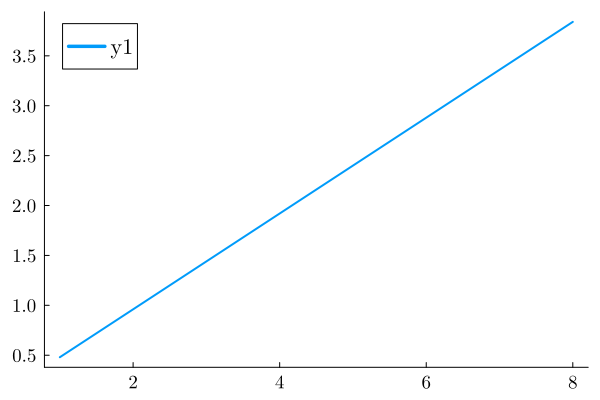

In [18]:
params_H1b = deepcopy(params)
H1b_vec = zeros(length(1:0.01:8))
for (i,scale) in enumerate(1:0.01:8)
    params_H1b[:scale] = scale
    params_H1b = scale_parameters(params_H1b)
    H1b_vec[i] = params_H1b[:H1b]
end
plot(1:0.01:8, H1b_vec)

hi

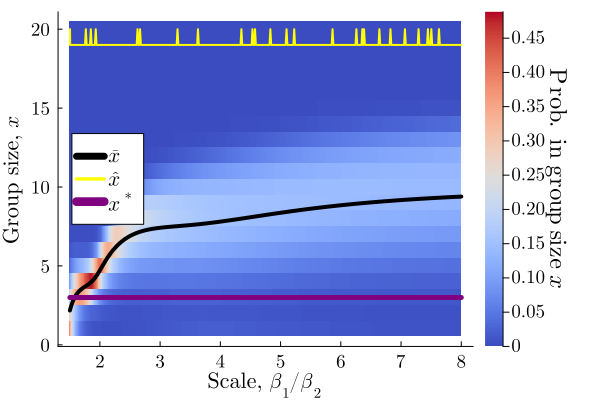

In [19]:
# get all the stable values and put in stable_coexist. separately also put g values in gmat
stable_coexist, gmat = get_stable_equilibria_from_br(br_co, p_nt;
        type_system = :oneprey)
plt = plot_distribution_heatmap(gmat, stable_coexist, p_nt.x_max)
plot_mc_line_1prey(plt, stable_coexist, params_base)
plot_opt_line_1prey(plt, stable_coexist, params_base)
plot!(legend = :left)
plot!(dpi=650)
savefig(plt, bif_fig_path*"bif_1prey_scale_T2_px.pdf")
plot!(dpi=100)

hi

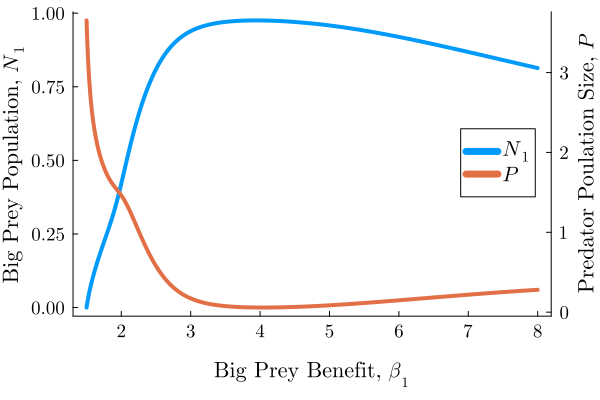

In [20]:
br_co = br_list[:coexist]
out_nt = extract_branch_matrix(br_co, p_nt.x_max; type_system = :oneprey)

plt = plot(
    out_nt.param, out_nt.N1, label = L"N_1", color = 1, linewidth = 4,
    ylabel = L"Big Prey Population, $N_1$",
    xlabel = "\n"*L"Big Prey Benefit, $\beta_1$",
    bottommargin=5mm)
plot!([],[],label = L"P", color = 2, linewidth = 4)
plot!(legend=:right)
plot!(
    twinx(), out_nt.param, out_nt.P, label = "", color = 2, linewidth = 4,
    ylabel = L"Predator Poulation Size, $P$"
)
plot!(dpi=650)
savefig(plt, bif_fig_path*"bif_1prey_scale_T2.pdf")
plot!(dpi=100)

hihihi

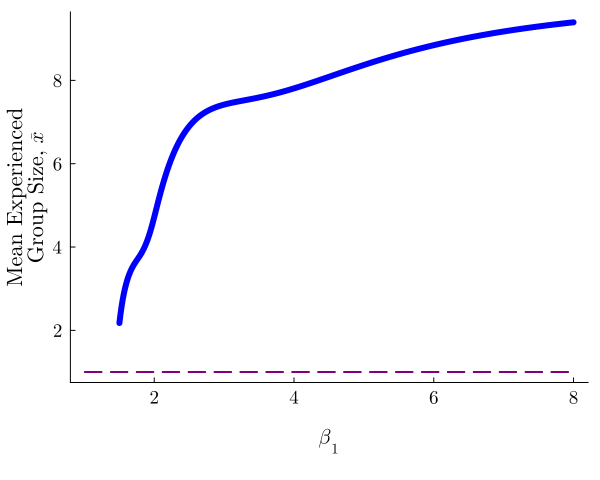

In [21]:
plot_nice_bif(br_list, :mean_x, :β1; p_nt.x_max, has_g = true, type_system = :oneprey)

hihihihihihihihihi

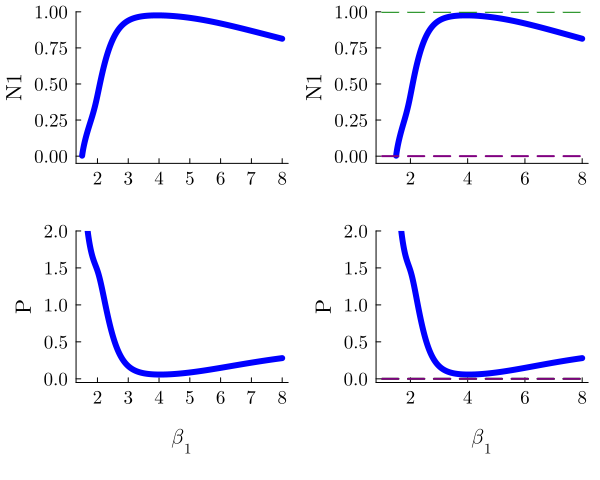

In [22]:
plot_comparison_branches_filtered(
        [br_co], br_list,:β1; 
        ymax = 2.0, has_g = true, x_max = 5,
        plot_fun = plot_nice_bif,
        type_system = :oneprey)

# Population Dynamics ONLY

## Type I

In [324]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :x => 5.0,
    :scale => 5.0
)

params = deepcopy(params_base)


Dict{Symbol, Float64} with 12 entries:
  :A1      => 0.6
  :H2b     => 0.0
  :scale   => 5.0
  :s1      => 2.0
  :H1a     => 0.0
  :H2a     => 0.0
  :α2_of_1 => 0.95
  :η2      => 0.6
  :x       => 5.0
  :α1_of_1 => 0.05
  :A2      => 0.5
  :β2      => 1.0

In [325]:
function equilibrium_nogroups_bigpreyONLY(params)
    @unpack η1, η2 = params
    @unpack H1a, H1b = params
    @unpack β1, A1 = params
    @unpack x = params

    α1 = fun_alpha1(x,params)
    H1 = H1a .+ H1b./x
    td = 1 - η1 - η2

    N1 = x .* td ./ (α1 .* (β1 * A1 .- x .* H1 .* td))
    P = (η1 * β1 / td) .* N1 .* (1 .- N1)

    return N1, P
end

equilibrium_nogroups_bigpreyONLY (generic function with 2 methods)

In [327]:
params = deepcopy(params_base)
params = scale_parameters(params)

Dict{Symbol, Float64} with 15 entries:
  :A1      => 0.6
  :η1      => 0.12
  :H2b     => 0.0
  :scale   => 5.0
  :s1      => 2.0
  :H1a     => 0.0
  :H2a     => 0.0
  :α2_of_1 => 0.95
  :η2      => 0.6
  :x       => 5.0
  :α1_of_1 => 0.05
  :β1      => 5.0
  :H1b     => 0.0
  :A2      => 0.5
  :β2      => 1.0

In [328]:
using LinearAlgebra, ForwardDiff

In [386]:
# Grids - scale by x (discrete)

nscale = 300
nx = 8

params = deepcopy(params_base)
scale_vec = range(start=1.01,stop = 8.0, length = nscale)
xvec = collect(1:nx)

Pmat = fill(NaN, nx, nscale)
N1mat = fill(NaN, nx, nscale)
for (j, scale) in enumerate(scale_vec)
    for (i, x) in enumerate(xvec)
        #update parameters
        params[:scale] = scale
        params[:x] = x
        params = scale_parameters(params)
        
        # get N1, P
        N1, P = equilibrium_nogroups_bigpreyONLY(params)

        u_eq = [N1, 0, P]

        # stability
        J = ForwardDiff.jacobian(u -> system_nogroups(u, params, 1),u_eq)
        M = J[1:end .!=2, 1:end .!=2]
        evals_real = real(eigen(M).values)

        if all( [N1,P] .> 0) && all(evals_real .< 0)
            Pmat[i, j] = P
            N1mat[i, j] = N1
        end
    end
    
end

extinction_mat = fill(NaN, nx, nscale)
for (j, scale) in enumerate(scale_vec)
    for (i, x) in enumerate(xvec)
        #update parameters
        params[:scale] = scale
        params[:x] = x
        params = scale_parameters(params)
        
        # get N1, P
        N1, P = equilibrium_nogroups_bigpreyONLY(params)


        # stability
        J = ForwardDiff.jacobian(u -> system_nogroups(u, params, 1),[1,0,0])
        M = J[1:end .!=2, 1:end .!=2]
        evals_real = real(eigen(M).values)

        if all(evals_real .< 0)
            extinction_mat[i, j] = 1
        end
    end
    
end



In [387]:
sum(extinction_mat.>0 .&& Pmat.>0)

0

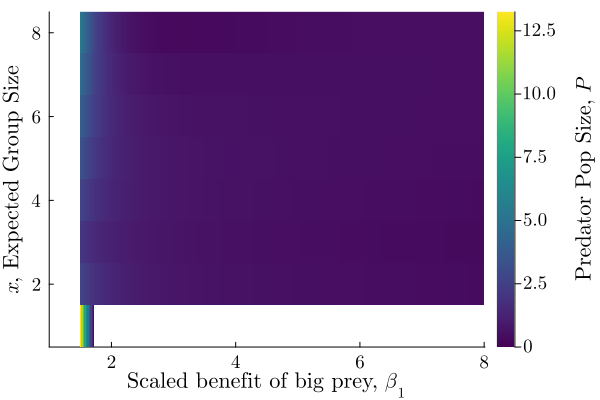

In [398]:
maxP = maximum(Pmat[.!isnan.(Pmat)], dims = 1)[1]
hm_P = heatmap(
    scale_vec, xvec, Pmat;
    xlabel = L"Scaled benefit of big prey, $\beta_1$",
    ylabel = L"$x$, Expected Group Size",
    colorbar_title = "\n"*L"Predator Pop Size, $P$",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, maxP),
    right_margin = 8mm,
    colorbar_titlefontsize = 14
)
savefig(hm_P, bif_fig_path*"popdyn_1prey_typeI_P.png")
hm_P


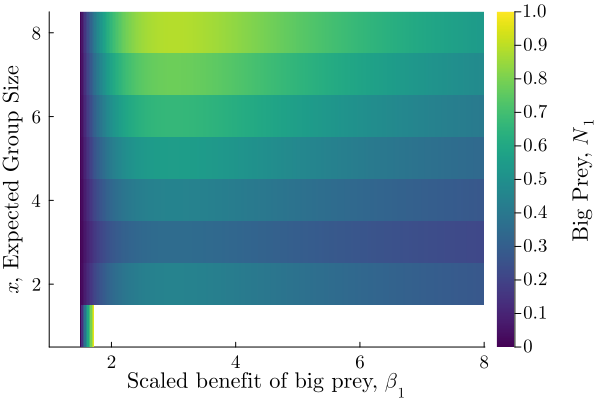

In [399]:
hm_N = heatmap(
    scale_vec, xvec, N1mat;
    xlabel = L"Scaled benefit of big prey, $\beta_1$",
    ylabel = L"$x$, Expected Group Size",
    colorbar_title = "\n"*"Big Prey, "*L"N_1",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, 1),
    right_margin = 8mm,
    colorbar_titlefontsize = 14
)
savefig(hm_N, bif_fig_path*"popdyn_1prey_typeI_N1.png")
hm_N

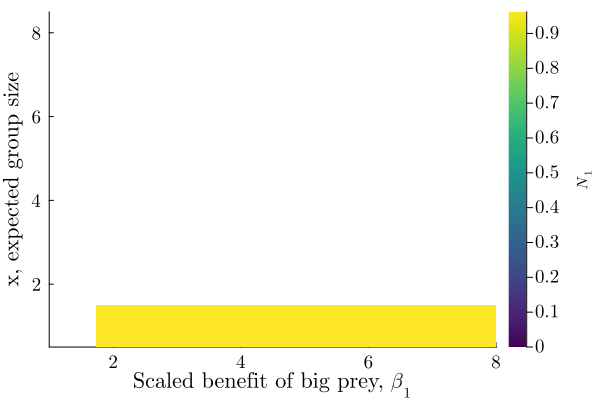

In [333]:


hm_extinction = heatmap(
    scale_vec, xvec, extinction_mat;
    xlabel = L"Scaled benefit of big prey, $\beta_1$",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*L"N_1",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, maxP),
    right_margin = 5mm 
)

# type II

In [450]:
# Grids - scale by x (discrete)

nscale = 300
nx = 8

params = deepcopy(params_base)
params[:H2b] = 1.0
scale_vec = range(start=1.01,stop = 8.0, length = nscale)
xvec = collect(1:nx)

Pmat = fill(NaN, nx, nscale)
N1mat = fill(NaN, nx, nscale)
for (j, scale) in enumerate(scale_vec)
    for (i, x) in enumerate(xvec)
        #update parameters
        params[:scale] = scale
        params[:x] = x
        params = scale_parameters(params)
        
        # get N1, P
        N1, P = equilibrium_nogroups_bigpreyONLY(params)

        u_eq = [N1, 0, P]

        # stability
        J = ForwardDiff.jacobian(u -> system_nogroups(u, params, 1),u_eq)
        M = J[1:end .!=2, 1:end .!=2]
        evals_real = real(eigen(M).values)

        if all( [N1,P] .> 0) && all(evals_real .< 0)
            Pmat[i, j] = P
            N1mat[i, j] = N1
        end
    end
    
end

extinction_mat = fill(NaN, nx, nscale)
for (j, scale) in enumerate(scale_vec)
    for (i, x) in enumerate(xvec)
        #update parameters
        params[:scale] = scale
        params[:x] = x
        params = scale_parameters(params)
        
        # get N1, P
        N1, P = equilibrium_nogroups_bigpreyONLY(params)


        # stability
        J = ForwardDiff.jacobian(u -> system_nogroups(u, params, 1),[1,0,0])
        M = J[1:end .!=2, 1:end .!=2]
        evals_real = real(eigen(M).values)

        if all(evals_real .< 0)
            extinction_mat[i, j] = 1
        end
    end
    
end



In [401]:
sum(extinction_mat.>0 .&& Pmat.>0)

0

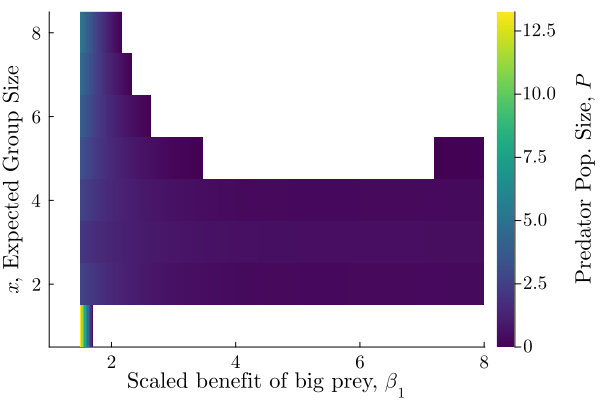

In [402]:
maxP = maximum(Pmat[.!isnan.(Pmat)], dims = 1)[1]
hm_P = heatmap(
    scale_vec, xvec, Pmat;
    xlabel = L"Scaled benefit of big prey, $\beta_1$",
    ylabel = L"$x$, Expected Group Size",
    colorbar_title = "\n"*L"Predator Pop. Size, $P$",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, maxP),
    right_margin = 8mm,
    colorbar_titlefontsize = 14
)
savefig(hm_P, bif_fig_path*"popdyn_1prey_typeII_P.png")
hm_P

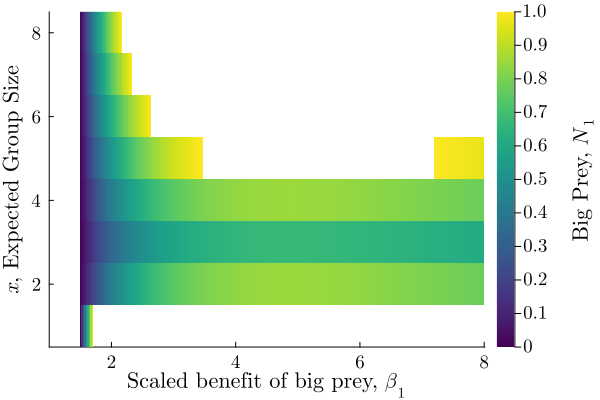

In [403]:
maxN1 = maximum(N1mat[.!isnan.(N1mat)], dims = 1)[1]
hm_N1 = heatmap(
    scale_vec, xvec, N1mat;
    xlabel = L"Scaled benefit of big prey, $\beta_1$",
    ylabel = L"$x$, Expected Group Size",
    colorbar_title = "\n"*L"Big Prey, $N_1$",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, 1),
    right_margin = 8mm,
    colorbar_titlefontsize = 14
)
savefig(hm_N1, bif_fig_path*"popdyn_1prey_typeII_N1.png")
hm_N1

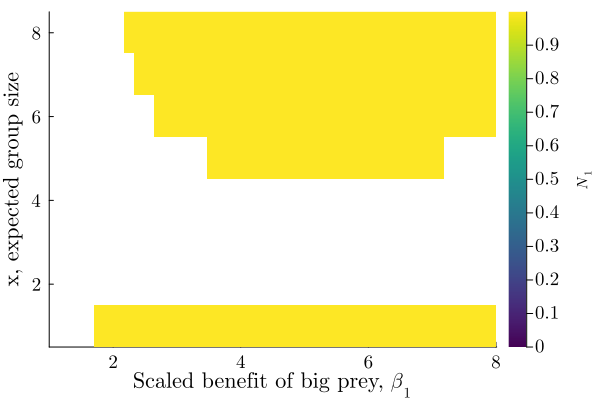

In [340]:


hm_extinction = heatmap(
    scale_vec, xvec, extinction_mat;
    xlabel = L"Scaled benefit of big prey, $\beta_1$",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*L"N_1",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, maxP),
    right_margin = 5mm 
)

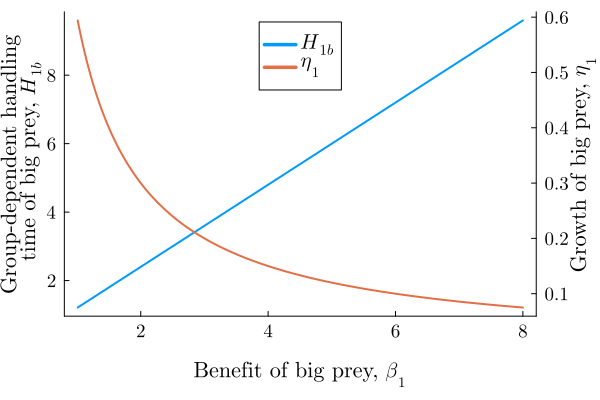

In [383]:
H1bvec = zeros(length(scale_vec))
η1vec = similar(H1bvec)
for (j, scale) in enumerate(scale_vec)
    params[:scale] = scale
    params = scale_parameters(params)
    H1bvec[j] = params[:H1b]
    η1vec[j] = params[:η1]
end

lineplot = plot(scale_vec, H1bvec, color = 1, label = L"H_{1b}")
plot!([],[],color=2,label = L"\eta_1")
plot!(
    xlabel = "\n"*L"Benefit of big prey, $\beta_1$",
    bottommargin = 5mm,
    ylabel = "Group-dependent handling"*"\n"*L" time of big prey, $H_{1b}$")
plot!(legend=:top)
plot!(twinx(),
    scale_vec, η1vec,
    color = 2,
    label = "",
    ylabel = L"Growth of big prey, $\eta_1$")
savefig(lineplot, bif_fig_path*"popdyn_1prey_typeII_params.png")
lineplot

## Get Do_base_continuations to work

In [174]:
x_max = p_nt.x_max
systemfunction = CoupledDynamics_1Prey_ODE
lens = (@optic _.scale)
lens = (@optic _.scale)
p_min = 1.01; p_max = 8.0; dsmax = 0.01
type_system = :oneprey

:oneprey

In [182]:
kargs = (
            systemfunction = systemfunction, 
            lens = (@optic _.scale), p_min = p_min, 
            p_max = p_max,
            type_system = type_system)

u0 = [0.8, 0.1, fill(0.001, x_max-1)...]
@assert eltype(u0) === Float64 "u0 must be Vector{Float64}, got eltype=$(eltype(u0))"
u0 = iterate_to_last_pt_scaled(u0, p_nt; tf = 500, systemfunction = systemfunction)
br_co = do_continuation(u0, p_nt; kargs...)

[0.7783345798529838, 0.0015388686634164794, 0.0005322663282631028, 0.0008372986082915701, 0.0017733838997592997, 0.0031445141297954332, 0.004657905605503803, 0.005914761485735743, 0.006571901050670194, 0.006489298631805627, 0.005750801314239845, 0.004532119159251721, 0.002922395002972732, 0.0012010983283629144, 0.00022540766103144373, 1.6381583880333074e-5]

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 498
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.01000000,                                                                     step =   0
- #  2, endpoint at scale ≈ +8.00000000,                                                                     step = 497


In [184]:
record_from_solution = recordFromSolution_1Prey
systemfunction = CoupledDynamics_1Prey_ODE

prob = BifurcationProblem(systemfunction, u0, p_nt,
            # specify the continuation parameter)
            lens, record_from_solution = record_from_solution)
print(prob)
opts_br = ContinuationPar(
            # parameter interval
            p_min = p_min, p_max = p_max, dsmax = dsmax,
            # detect bifurcations with bisection method
            # we increase the precision of the bisection
            n_inversion = 8 )
br = continuation(prob, PALC(), opts_br;
            # we want to compute both sides of the branch of the initial
            # value of E0 = -2
            bothside = true)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace:  false
├─ Dimension:  16
├─ Symmetric: false
└─ Parameter: scale

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 615
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.4520096858783451, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.45194883,                                                                     step =  -1
- #  2,       bp at scale ≈ +1.49999923 ∈ (+1.49999923, +1.50000014), |δp|=9e-07, [converged], δ = (-1,  0), step = 134
- #  3, endpoint at scale ≈ +8.00000000,                                                                     step = 614


In [179]:
opts_br

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.01
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 1.01
  p_max: Float64 8.0
  max_steps: Int64 400
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 3
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 8
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


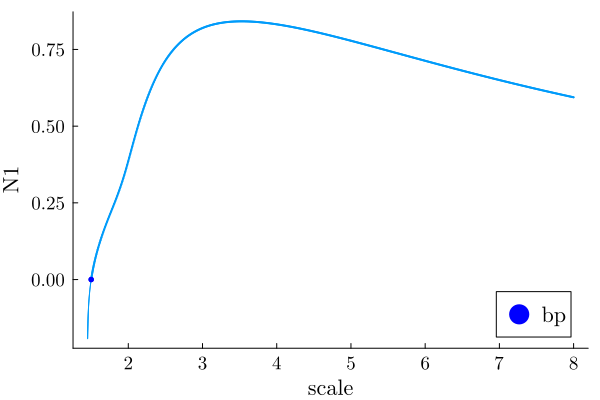

In [165]:
plot(br)

In [166]:
br_list = do_base_continuations_1prey(p_nt, p_nt.x_max; lens = (@optic _.scale), 
        p_min = 1.01, p_max = 8.0, systemfunction =CoupledDynamics_1Prey_ODE, dsmax = 0.01)

 got that one prey system got that one prey system got that one prey system

(coexist =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 498
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.01000000,                                                                     step =   0
- #  2, endpoint at scale ≈ +8.00000000,                                                                     step = 497
, predator_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 498
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.01000000,                                                                     step =   0
- #  2, endpoint at scale ≈ +8.00000000,                                                                     step = 497
, N1P_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 498
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale

In [123]:
br_list, extra_branches = diagram_2_recursion(p_nt; paramkey = :scale, 
        lens = (@optic _.scale), 
        p_min = 1.1, p_max = 8.0, 
        systemfunction = CoupledDynamics_1Prey_ODE, 
        system_type = :oneprey,
        dsmax = 0.01)

((coexist =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 491
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.1, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.10000000,                                                                     step =   0
- #  2, endpoint at scale ≈ +8.00000000,                                                                     step = 490
, predator_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 491
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale starts at 1.1, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at scale ≈ +1.10000000,                                                                     step =   0
- #  2, endpoint at scale ≈ +8.00000000,                                                                     step = 490
, N1P_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 491
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter scale 

hihihihihihihihihihihihihi

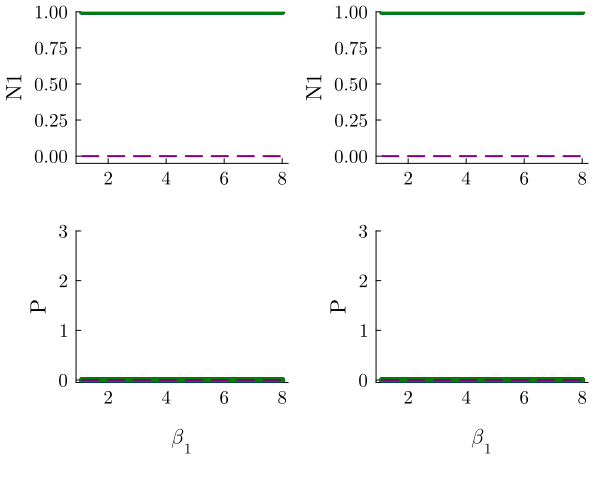

In [124]:
plot_comparison_branches_filtered(
        br_list, br_list, :β1; 
        ymax = 3.0, has_g = true, x_max = p_nt.x_max,
        plot_fun = plot_nice_bif,
        type_system = :oneprey)

In [ ]:
findmax(br_list.coexist.mean_x)[1]

(10.671117187726749, 309)

hihihihihihihas g so plotting x barhihihi

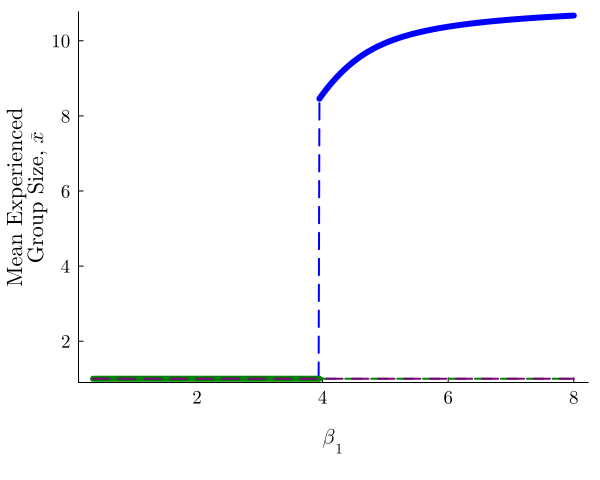

In [88]:
has_g = true
kargs = (has_g = has_g, type_system = :oneprey)
param_key = :β1
P_lims = nothing
pltP = plot_nice_bif(
            br_list, :P, param_key; 
            ylims = P_lims,
            kargs...
            )
pltN1 = plot_nice_bif(
            br_list, :N1, param_key; kargs...
            )
if has_g
            print("has g so plotting x bar")
            pltxbar = plot_nice_bif(
                br_list, :mean_x, param_key; kargs...
                )
            plot!(ylims=[0.9, findmax(br_list.coexist.mean_x)[1]+.1])
            #savefig(pltxbar, bif_fig_path*"meanx_"*fn_string_base*".pdf")
            #return (P=pltP, N1 = pltN1, mean_x = pltxbar)
        end

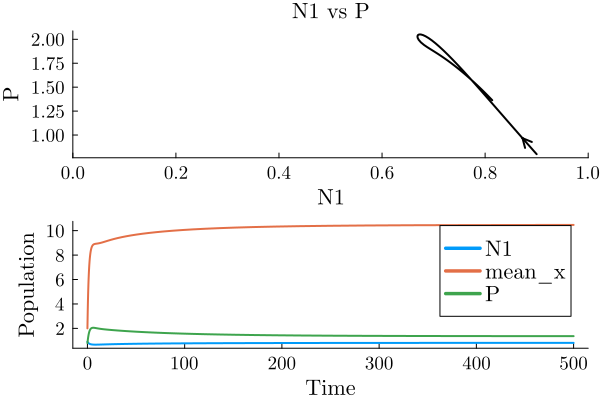

In [134]:
sol, fullplot = simulate_and_plot_1prey(
        u0, p_nt; tf = 500, system = CoupledDynamics_1Prey_ODE!,
        start_ind = nothing
        )
fullplot

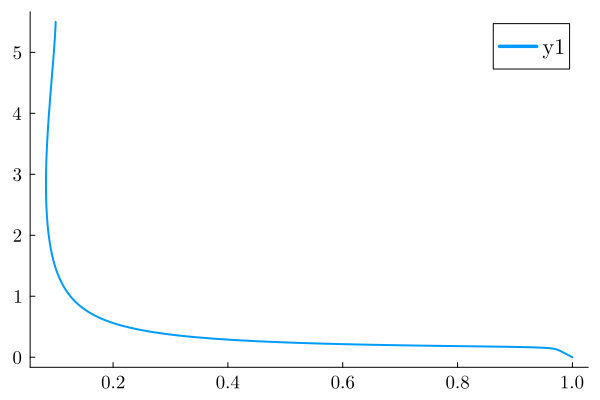

In [103]:
tspan = (0.0, 500.0)
prob = ODEProblem(CoupledDynamics_1Prey_ODE!, u0, tspan, p_nt)
sol = solve(prob)
N1 = sol[1, :] 
g = sol[2:end,:]

mean_x = get_meanx(g,10)
p = get_p(g,10)

plot(N1,mean_x')
plot(N1,p')

In [72]:
iterate_to_last_pt_scaled(u0, p_nt; systemfunction = CoupledDynamics_1Prey_ODE!)

11-element Vector{Float64}:
 0.9999998739195778
 3.392617833428275e-8
 7.404731640054291e-9
 8.833563517948401e-9
 1.3560089131719872e-8
 1.688357333744278e-8
 1.730202720642009e-8
 1.5080086096998667e-8
 1.1444068598869257e-8
 7.691347983844219e-9
 4.6357467168972796e-9

In [69]:
methods(iterate_to_last_pt_scaled)

# 1 method for generic function "iterate_to_last_pt_scaled" from CooperativeHuntingPkg.MyBifTools:
 [1] iterate_to_last_pt_scaled(u0, p_nt; tf, systemfunction)
     @ ~/Documents/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/MyBifTools.jl:799

In [68]:
do_continuation(u0, NamedTuple(params_base); 
        systemfunction = CoupledDynamics_1Prey_ODE, lens = (@optic _.β1),
        p_min = 1.01, p_max = 8.0, dsmax = 0.01)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 498
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter β1 starts at 1.01, ends at 8.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at β1 ≈ +1.01000000,                                                                     step =   0
- #  2, endpoint at β1 ≈ +8.00000000,                                                                     step = 497
